# Automated Credit Card Fraud Detection

The data analyzed here is a set of 284,807 credit card transactions, of which 492 are fraudulent. Each point has 30 features and a label. 28 of the features are the result of a PCA transformation and scaling, effectively anonymizing the transactions. This may have caused data leakage, but that cannot be determined without more information as to how the PCA was performed. [Here](https://www.kaggle.com/mlg-ulb/creditcardfraud) is where I sourced the data from.

The data are highly imbalanced, so we will need to either find a good way to artificially balance it or use a method that is resistant to imbalance. We will be doing the former, for the sake of practice. Out evaluation metrics will have to be chosen with care, as well.

Finally, the packages required for this notebook are all available in the standard Anaconda 3 installation - with one exception. If you with to run this yourself, you will need to install the [imbalanced-learn](https://pypi.org/project/imbalanced-learn/) package.

## Library Imports

In [1]:
# Import necessary libraries
#----------------------------------------------------------#

# General data storage and manipulation
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit

# The model
from sklearn.linear_model import SGDClassifier

# Model evaluation
from sklearn.metrics import roc_auc_score, make_scorer, roc_curve, precision_recall_curve, auc

## Data Imports

In [2]:
# Grab the data
#----------------------------------------------------------#

data = pd.read_csv("Data/creditcard.csv")

## Preprocessing

There are a few minor issues with the data that we must address before moving on. The first is that two of the features - time and amount - have not yet been scaled. This could impact the performance of our model if not corrected. The second is that the feature matrix and label vector are combined. This is easily resolved.

In [3]:
# Scale the yet unscaled features
#----------------------------------------------------------#

rob_scaler = RobustScaler()

time_scaled = rob_scaler.fit_transform(data['Time'].values.reshape(-1, 1))
amount_scaled = rob_scaler.fit_transform(data['Amount'].values.reshape(-1, 1))

data.drop(['Time', 'Amount'], axis = 1, inplace = True)

data.insert(0, 'time_scaled', time_scaled)
data.insert(1, 'amount_scaled', amount_scaled)

In [4]:
# Create the feature matrix and label vector
#----------------------------------------------------------#

X = data.drop('Class', axis = 1)
y = data['Class']

## Model Selection

We will eschew data exploration here, if only because others have done so exhaustively and written beautiful reports on it.

Now that we have constructed our feature matrix and label vector, it is time to select a model for the data. Here, we will test four models with five-fold grid search cross validation: the logistic and robust logistic models with the l1 and l2 metrics. The selection metric I chose is the area under the receiver operating characteristic. This is not the ideal metric - that is the area under the precision recall curve - but it is good enough. It is worth noting that we are testing only smooth models. This is so that we can see the impact of different model sensitivities later on.

We will be using a stratified shuffle split to get our training set to keep the class ratio equal. We will also be using the Synthetic Minority Oversampling Technique (SMOTE) to oversample our training set and balance the classes. In essence, this amounts to assuming that the class of fraudulent transactions is approximately simply connected in our feature space. This may not be true, in which case model performance will be negatively affected.

In [5]:
# Find the best model parameters
#----------------------------------------------------------#

# Split the data into train and test sets. Stratified to account
# for disparate class sizes.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Oversample with SMOTE to balance class sizes.
sampler = SMOTE()
X_train, y_train = sampler.fit_resample(X_train, y_train)

# Define the model and use Grid Search CV to find best model parameters.
# Maximizes AUC-ROC
params = {'loss': ['log', 'modified_huber'], 
          'penalty': ['l1', 'l2']}
clf = SGDClassifier(max_iter = 1000, tol = 1e-3)
scorer = make_scorer(roc_auc_score, needs_proba = True)
cv = GridSearchCV(estimator = clf, 
                  param_grid = params, 
                  scoring = scorer, 
                  n_jobs = -1,
                  cv = 5)

model = cv.fit(X_train, y_train)

## Model Evaluation

Now that we have selected a model - logistic regression with the l1 norm - it is time to find out how well it performs on the data. Our metrics of choice are the receiver operating characteristic, the precision-recall curve, and the areas under each. These should give some idea of real-world performance on highly imbalanced classification tasks.

Due to the low training time required (on the order of a few seconds) we will reshuffle and split the data, train, test, and evaluate 1000 times. This takes around two hours on a reasonably fast laptop.

In [6]:
# Fit the model with best parameters and get the ROC, PRC, 
# AUC-ROC, and AUC-PRC. Repeats 1000 times, using different 
# training and testing sets each time.
#----------------------------------------------------------#

splitter = StratifiedShuffleSplit(n_splits = 1000)

roc_aucs = []
prc_aucs = []
precisions = []
recalls = []
fprs = []
tprs = []

for train, test in splitter.split(X, y):
    # Split the testing and training sets.
    X_train = X.iloc[train].values
    X_test = X.iloc[test].values
    y_train = y.iloc[train].values
    y_test = y.iloc[test].values
    
    # Oversample minority classes with SMOTE to balance.
    sampler = SMOTE()
    X_train, y_train = sampler.fit_resample(X_train, y_train)
    
    # Fit the best model tested.
    clf = model.best_estimator_
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    
    # Determine the ROC and PRC.
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Evaluate and store metrics.
    roc_aucs.append(roc_auc_score(y_test, y_pred))
    prc_aucs.append(auc(recall, precision))
    precisions.append(precision)
    recalls.append(recall)
    fprs.append(fpr)
    tprs.append(tpr)

## Visualizing Model Performance

That done, we can now visualize the performance of our model. In the line charts, the lightly shaded region spans the 0.05 to 0.95 quantiles, and the darker shaded region the 0.25 to 0.75 quantiles. The line is the mean at each point.

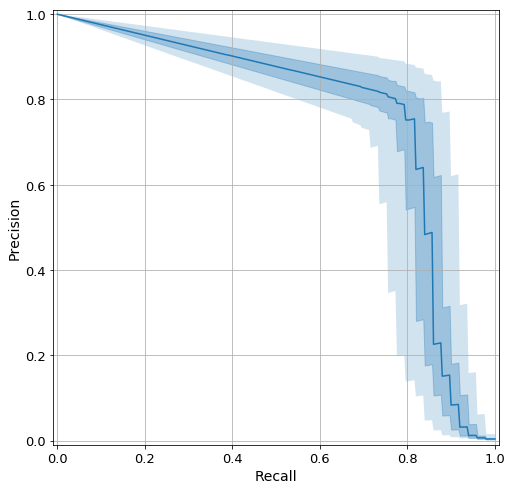

In [16]:
# Graph the 5%, 25%, 50%, 75%, and 95% quartile PRCs.
#----------------------------------------------------------#

#  Perform linear interpolation to make PRC matrix.
int_recalls = np.linspace(0, 1, 300)
int_precisions = np.interp(x = int_recalls,
                           xp = recalls[0][::-1], 
                           fp = precisions[0][::-1])
for i in range(len(recalls) - 1):
    int_precision = np.interp(x = int_recalls,
                              xp = recalls[i + 1][::-1], 
                              fp = precisions[i + 1][::-1])
    int_precisions = np.vstack((int_precisions, int_precision))

# Find quantile curves.
lower_precision = np.quantile(int_precisions, 0.05, axis = 0)
low_precision = np.quantile(int_precisions, 0.25, axis = 0)
med_precision = np.median(int_precisions, axis = 0)
high_precision = np.quantile(int_precisions, 0.75, axis = 0)
higher_precision = np.quantile(int_precisions, 0.95, axis = 0)

# Plot curves with quantiles filled.
plt.figure(figsize = (8, 8))
plt.plot(int_recalls, med_precision)
plt.fill_between(int_recalls, lower_precision, higher_precision, alpha = 0.2)
plt.fill_between(int_recalls, low_precision, high_precision, alpha = 0.3, color = "C0")
plt.xlabel("Recall", fontsize = 14)
plt.ylabel("Precision", fontsize = 14)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.grid(True)
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01));

plt.savefig("PRCs.jpg", bbox_inches = "tight")

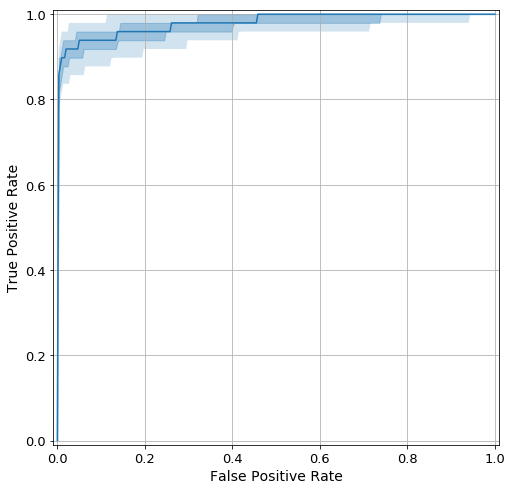

In [15]:
# Graph the 5%, 25%, 50%, 75%, and 95% quartile ROCs.
#----------------------------------------------------------#

#  Perform linear interpolation to make ROC matrix.
int_fprs = np.linspace(0, 1, 300)
int_tprs = np.interp(x = int_fprs,
                     xp = fprs[0], 
                     fp = tprs[0])
for i in range(len(fprs) - 1):
    int_tpr = np.interp(x = int_fprs,
                        xp = fprs[i + 1], 
                        fp = tprs[i + 1])
    int_tprs = np.vstack((int_tprs, int_tpr))

# Find quartile curves.
lower_tpr = np.quantile(int_tprs, 0.05, axis = 0)
low_tpr = np.quantile(int_tprs, 0.25, axis = 0)
med_tpr = np.median(int_tprs, axis = 0)
high_tpr = np.quantile(int_tprs, 0.75, axis = 0)
higher_tpr = np.quantile(int_tprs, 0.95, axis = 0)

# Plot curves with quartiles filled.
plt.figure(figsize = (8, 8))
plt.plot(int_fprs, med_tpr)
plt.fill_between(int_fprs, lower_tpr, higher_tpr, alpha = 0.2)
plt.fill_between(int_fprs, low_tpr, high_tpr, alpha = 0.3, color = "C0")
plt.xlabel("False Positive Rate", fontsize = 14)
plt.ylabel("True Positive Rate", fontsize = 14)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.grid(True)
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01));

plt.savefig("ROCs.jpg", bbox_inches = "tight")

ROC Mean: 0.9764658619778807
ROC Standard Deviation: 0.01463399522372115


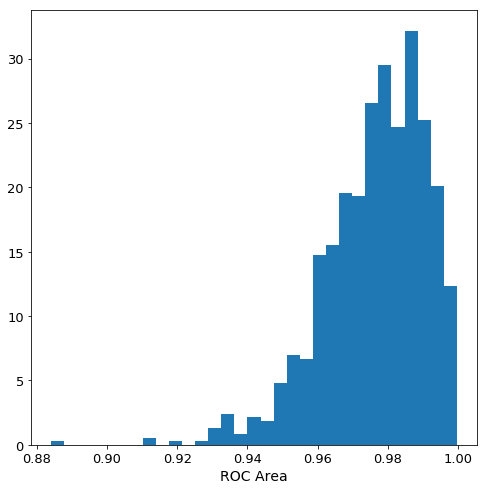

In [22]:
# Plot a histogram of AUC-ROCs, binned with Freedman-Dianconis.
#----------------------------------------------------------#

plt.figure(figsize = (8, 8))
plt.hist(roc_aucs, bins = "fd", density = True)
plt.xlabel("ROC Area", fontsize = 14)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13);

plt.savefig("AUCROCs.jpg", bbox_inches = "tight")

print("ROC Mean: {}".format(np.mean(roc_aucs)))
print("ROC Standard Deviation: {}".format(np.std(roc_aucs)))

PRC Mean: 0.7658035246000857
PRC Standard Deviation: 0.05153876381741216


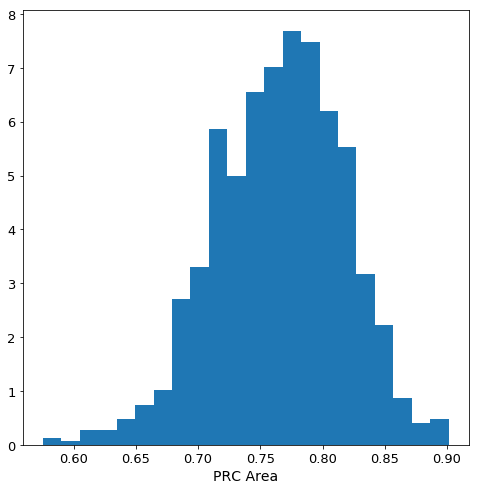

In [23]:
# Plot a histogram of AUC-PRCs, binned with Freedman-Dianconis.
#----------------------------------------------------------#

plt.figure(figsize = (8, 8))
plt.hist(prc_aucs, bins = "fd", density = True)
plt.xlabel("PRC Area", fontsize = 14)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13);

plt.savefig("AUCPRCs.jpg", bbox_inches = "tight")

print("PRC Mean: {}".format(np.mean(prc_aucs)))
print("PRC Standard Deviation: {}".format(np.std(prc_aucs)))

## Conclusions

Our model performs fairly well on the data, capable of 0.8/0.8 recall/precision in the median case. The variation in model performance over training sets indicates that this could be improved with data on more fraudulent transactions. Future work could also explore the performance impact of different undersampling, resampling, and oversampling techniques and checking if using the area under the precision recall curve as a selection metric during model selection results in the selection of a different model.